In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize
import json, pickle

## Write test data
<h3><font color="red">WARNING: this will update test files.</font></h3>

This may cause tests that depend on fit-values to fail.  To run, uncomment `write_new_test_data()` below.

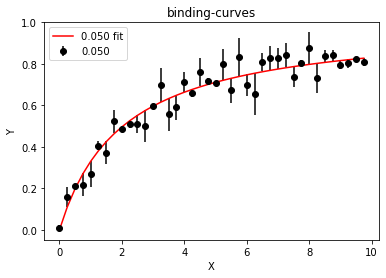

In [4]:

def model(K,X):
    """
    Simple, saturating binding curve.

    K: association constant
    X: vector of X concentrations
    """

    return K*X/(1 + K*X)

def model_residual(params,X,Y):
    """
    Residual for fitting a simple saturating binding curve.
    
    params: array with fit parameters: (K,) in this case
    X: vector of X concentrations
    Y: vector of Y observations"""
    
    return model(params[0],X) - Y
    
    
def write_new_test_data(K=0.5,
                        guess=1,
                        noise=0.05,
                        y_stdev=0.05,
                        X_concs=np.arange(0,10,0.25),
                        prefix="binding-curves"):
       
    name = f"{noise:.3f}"

    json_dict = {}
    json_dict["input_params"] = (K,)
    json_dict["guesses"] = (guess,)
    
    # Create fake data with noise and write out
    noise = np.random.normal(0,noise,len(X_concs))
    frac_sat = model(K,X_concs) + noise
    Y_stdev = np.abs(noise)
    residual = frac_sat - model(K,X_concs)
    weighted_residual = residual/Y_stdev
    sigma2 = Y_stdev**2
        
    df = pd.DataFrame({"X":X_concs,
                       "Y":frac_sat,
                       "Y_stdev":Y_stdev,
                       "residual":residual,
                       "weighted_residual":weighted_residual})
    
    csv_out = f"{prefix}_noise-{name}.csv"
    df.to_csv(csv_out)
    json_dict["test_file"] = csv_out

    # Record log likelihood
    json_dict["ln_like"] = -0.5*(np.sum((frac_sat - model(K,X_concs))**2/sigma2 + np.log(sigma2)))
    
    
    # Fit model to data
    fit = scipy.optimize.least_squares(model_residual,
                                       [guess],
                                       kwargs={"X":X_concs,"Y":frac_sat})
    json_dict["fit_params"] = tuple(fit.x)
    
    # Create plot 
    fig, ax = plt.subplots()
    
    ax.errorbar(df.X,df.Y,yerr=df.Y_stdev,fmt="o",color="black",label=name)
    ax.plot(df.X,model(fit.x[0],df.X),"-",color="red",label=f"{name} fit")
    ax.legend()
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title(f"{prefix}")
    fig.savefig(f"{prefix}.pdf")
    
    plt.show()
    
    json.dump(json_dict,open(f"{prefix}.json","w"))
    

write_new_test_data()